# Solving the "mountain car" task using NESTML

In this tutorial, we are going to build an agent that can successfully solve the "mountain car" task using a biologically plausible form of reinforcement learning (reward-modulated STDP).

The "mountain car" task is a classic reinforcement learning control problem where an underpowered car must reach a goal position on top of a hill by exploiting momentum dynamics. The agent observes a continuous 2D state space (position and velocity of the car) and selects from discrete actions (accelerate left, no action, accelerate right) to maximize the reward. The car's engine is insufficient to directly climb the steep slope, requiring the agent to learn an oscillatory policy that builds momentum by driving backward up the opposite hill before gaining enough kinetic energy to reach the goal.

Typically, the mountain car problem is formulated as a sparse reward problem: while the agent is exploring, no reward is given. Only at the very end of a successful trial (the car having reached the end goal), is a sudden large reward given. The sparsity of the reward problem makes the mountain-car task especially challenging for exploration strategies in reinforcement learning algorithms. For the spiking network controller, we make the task easier by using *reward shaping:* a reward is given at every timestep, proportional to the performance of the agent at that time. This tutorial encourages you to play around with different reward shaping algorithms, but they typically include terms involving speed and height achieved.

As a reference point, We will start by using a standard temporal difference (Q-learning) approach and after that, use NESTML to perform the task using a spiking neural network.

## Mountain car environment

For the environment, we mostly need:  
- A renderer to display the simulation;
- The physical system (differential equations)
    
We will use the popular "pygame" package to do the rendering [3].

In [1]:
from typing import List, Tuple, Optional

from collections import defaultdict

import copy
import enum
import json
import matplotlib as mpl
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import sys
import time

import pygame

import nest

nest.set_verbosity("M_ERROR")
nest_local_num_threads = 1

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "k"
mpl.rcParams["grid.linestyle"] = ":"
mpl.rcParams["grid.linewidth"] = 0.5
mpl.rcParams['axes.formatter.useoffset'] = False   # never use offsets on any axis
mpl.rcParams['axes.formatter.use_locale']  = False # optional: also suppress 1 000→1,000 locale formatting

pygame 2.5.0 (SDL 2.28.0, Python 3.11.4)
Hello from the pygame community. https://www.pygame.org/contribute.html

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jun  2 2025 16:24:58

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



### Physics of the mountain car task

The ``MountainCarPhysics`` class simulates the physics of the mountain-car environment. The environment is modeled as a car on a one-dimensional track, shaped by a sinusoidal function.

The state of the system is defined by the car's position, $x$, and velocity, $v$. The dynamics are influenced by a constant gravitational force and a control force, $F$, applied by the agent.

The height of the track, $h$, at any given position $x$ is defined by:
$$ h(p) = 0.45 \sin(3x) + 0.55 $$

The car's movement is governed the following set of ordinary differential equations (ODEs):

$$ \frac{dv}{dt} = F - g \cos(3x) $$
$$ \frac{dx}{dt} = v $$

Where:
- $v$ is the velocity of the car.
- $x$ is the position of the car.
- $F$ is the force applied by the agent (either positive, negative, or zero).
- $g$ is the gravitational constant.

These equations are discretized using the Forward Euler method for the simulation update:

$$ v_{t+1} = v_t + (F - g \cos(3x_t)) $$
$$ x_{t+1} = x_t + v_{t+1} \cdot \Delta t $$

Note that the velocity is updated first and then used to update the position. The velocity and position are subsequently clamped to their respective predefined minimum and maximum values.


In [2]:
class MountainCarPhysics:
    def __init__(self,
                    dt: float = 10E-3,
                    POS_MIN = -1.5,
                    POS_MAX = 0.6,
                    VEL_MIN = -0.07,
                    VEL_MAX = 0.07,
                    GOAL_POS = 0.5,
                    GRAVITY = 0.0025,
                    FORCE_MAG = 0.0005) -> None:

        self.min_position = POS_MIN
        self.max_position = POS_MAX
        self.min_velocity = VEL_MIN
        self.max_velocity = VEL_MAX
        self.goal_position = GOAL_POS
        self.force_mag = FORCE_MAG
        self.gravity = GRAVITY
        self.dt = dt / 10E-3  # normalize timestep
        
        self.state = self.reset()

    def _height(self, pos):
        """Calculate the height of the mountain at a given position.
        
         Shape is a scaled sine wave.
         """
        return np.sin(3 * pos) * 0.45 + 0.55

    def reset(self):
        r"""
        Resets the environment to a starting state.
        
        Start near the bottom with zero velocity.
        """
        start_pos = random.uniform(-0.6, -0.4)
        start_vel = 0.0
        self.state = (start_pos, start_vel)

        return self.state

    def step(self, action):
        """
        Applies an action, updates the state, and returns new state.
        """
        position, velocity = self.state
        assert action in AgentAction, "Invalid action"

        # Physics update
        force = 0.
        if action == AgentAction.LEFT:
            force = -self.force_mag
        elif action == AgentAction.RIGHT:
            force = self.force_mag

        velocity += force - self.gravity * np.cos(3 * position)
        velocity = max(self.min_velocity, min(self.max_velocity, velocity)) # Clamp velocity

        position += velocity * self.dt
        position = max(self.min_position, min(self.max_position, position)) # Clamp position

        # Check for goal
        done = bool(position >= self.goal_position or position <= self.min_position)

        self.state = (position, velocity)
        
        return self.state, done

    def get_state(self):
        return self.state

To render the environment for visual inspection, we make a class ``Renderer`` that uses pygame.

To prevent from slowing down the learning process, the visualisation is not shown by default. With the pygame window highlighted, press the spacebar to toggle the visualisation on/off.

In [3]:
class MountainCarRenderer:
    
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent
        self.CAR_WIDTH = 20
        self.CAR_HEIGHT = 10
        self.SCREEN_WIDTH = 600
        self.SCREEN_HEIGHT = 400
        
        self.FLAG_X = int((self.env.goal_position - self.env.min_position) / (self.env.max_position - self.env.min_position) * self.SCREEN_WIDTH)
        self.FLAG_Y_BASE = self.SCREEN_HEIGHT // 3
        self.FLAG_HEIGHT = 30
        
    def _init_render(self):
        """Initializes Pygame for rendering."""
        pygame.init()
        self.screen = pygame.display.set_mode((self.SCREEN_WIDTH, self.SCREEN_HEIGHT))
        pygame.display.set_caption("Mountain Car Environment")

        self.clock = pygame.time.Clock()
        try:
            self.font = pygame.font.Font(None, 24) # Default font
        except IOError:
            print("Pygame font not found, using fallback.")
            self.font = pygame.font.SysFont(pygame.font.get_default_font(), 24) # Fallback

    def render(self, episode=None, step=None, total_reward=None, action=None):
        """Renders the current state using Pygame."""
        if self.screen is None:
            self._init_render()

        # Handle quit events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                self.close()
                return False # Indicate rendering should stop

        self.screen.fill((255, 255, 255)) # White background

        # Draw the track
        track_points = []
        for i in range(self.SCREEN_WIDTH):
            pos = env.min_position + (env.max_position - env.min_position) * (i / self.SCREEN_WIDTH)
            height = env._height(pos)
            screen_y = self.SCREEN_HEIGHT - int(height * self.SCREEN_HEIGHT * 0.8) # Scale height
            track_points.append((i, screen_y))
        pygame.draw.lines(self.screen, (0, 0, 0), False, track_points, 2)

        # Draw the goal flag
        flag_world_y = env._height(env.goal_position)
        flag_screen_y = self.SCREEN_HEIGHT - int(flag_world_y * self.SCREEN_HEIGHT * 0.8)
        pygame.draw.line(self.screen, (200, 0, 0), (self.FLAG_X, flag_screen_y), (self.FLAG_X, flag_screen_y - self.FLAG_HEIGHT), 3)
        pygame.draw.polygon(self.screen, (200, 0, 0), [(self.FLAG_X, flag_screen_y - self.FLAG_HEIGHT),
                                                     (self.FLAG_X + 15, flag_screen_y - self.FLAG_HEIGHT + 5),
                                                     (self.FLAG_X, flag_screen_y - self.FLAG_HEIGHT + 10)])

        # Draw the car
        car_pos_norm = (self.env.state[0] - self.env.min_position) / (self.env.max_position - self.env.min_position)
        car_x = int(car_pos_norm * self.SCREEN_WIDTH)
        car_world_y = env._height(self.env.state[0])
        car_y = self.SCREEN_HEIGHT - int(car_world_y * self.SCREEN_HEIGHT * 0.8) # Position car on track

        # Simple rectangle for the car
        car_rect = pygame.Rect(car_x - self.CAR_WIDTH // 2, 
                               car_y - self.CAR_HEIGHT, 
                               self.CAR_WIDTH,
                               self.CAR_HEIGHT)
        pygame.draw.rect(self.screen, (0, 0, 200), car_rect) # Blue car

        # Display stats if available
        if episode is not None and self.font:
            stats_text = f"Episode: {episode} | Step: {step} | Reward: {total_reward:.2f}"
            if not action is None:
                stats_text += " | Action: "
                if action == AgentAction.LEFT:
                    stats_text += "L"
                else:
                    stats_text += "R"
            text_surface = self.font.render(stats_text, True, (0, 0, 0))
            self.screen.blit(text_surface, (10, 10))

        pygame.display.flip()
        self.clock.tick(30) # Limit frame rate
        return True # Indicate rendering succeeded

    def close(self):
        """Closes the Pygame window."""
        if self.screen is not None:
            print("Closing Pygame window.")
            pygame.quit()
            self.screen = None # Mark as closed

# The Agent

In the base class ``Agent``, we define some base functions:

- those for discretising the continous-valued environment state into discrete bins so that we can feed it into the neural network as a "one-hot" encoding.
- the reward function $\Phi$ (note that this is not yet the reward-shaped version that will be used in the spiking agent below).

The state is a set S of agent observable states. An action is a set of possible actions A in a state S. Usually, the actions that an agent can do are the same in all states.

In [4]:
class AgentAction(enum.Enum):
    LEFT = 0
    RIGHT = 1

class Agent:
    """
    Base class for an agent controlling the mountain car.
    """
    
    def __init__(self, env, NUM_POS_BINS: int = 10, NUM_VEL_BINS: int = 10) -> None:
        self.env = env
        self.pos_bins = self._create_bins(self.env.min_position, self.env.max_position, NUM_POS_BINS)
        self.vel_bins = self._create_bins(self.env.min_velocity, self.env.max_velocity, NUM_VEL_BINS)

        LEARNING_RATE = 0.1  # Alpha
        DISCOUNT_FACTOR = 0.99 # Gamma
        P_EXPLORE_START = 1.   # exploration ratio
        P_EXPLORE_END = 0.  # was: 0.01
        P_EXPLORE_DECAY = .993 # Decay factor per episode
        LEARNING_RATE_DECAY = .998  # learning rate usually decays less fast than exploration probability

        self.MIN_LEARNING_RATE = 0.01

        self.learning_rate = LEARNING_RATE
        self.discount_factor = DISCOUNT_FACTOR
        self.learning_rate_decay = LEARNING_RATE_DECAY
        self.p_explore = P_EXPLORE_START
        self.p_explore_decay = P_EXPLORE_DECAY
        self.p_explore_end = P_EXPLORE_END
        self.POTENTIAL_SCALE_POS = 10.0        
        self.NUM_POS_BINS = NUM_POS_BINS
        self.NUM_VEL_BINS = NUM_VEL_BINS
        
        self.rng = random.Random() # Local random number generator

    def _create_bins(self, min_val, max_val, num_bins):
        r"""Creates discretization bins."""
        if num_bins <= 1:
            return [] # No bins needed if only 1

        bin_size = (max_val - min_val) / num_bins

        # Create thresholds between bins
        return [min_val + i * bin_size for i in range(1, num_bins)]

    def _get_discrete_state(self, state):
        """Converts continuous state (pos, vel) to discrete state (pos_bin, vel_bin)."""
        position, velocity = state

        def _find_bin(value, bins):
            for i, threshold in enumerate(bins):
                if value < threshold:
                    return i
            return len(bins) # Return the last bin index if value >= last threshold

        pos_bin = _find_bin(position, self.pos_bins)
        vel_bin = _find_bin(velocity, self.vel_bins)

        return (pos_bin, vel_bin)
    
    def failure_reset(self, state: Tuple[float,float,float,float]):
        box = self.get_box(state)
        self.current_box = self.boxes[box[0], box[1], box[2], box[3], :]

    def decay_learning_rate(self):
        """Decays the learning rate."""
        self.learning_rate = self.learning_rate * self.learning_rate_decay
        if self.learning_rate < self.MIN_LEARNING_RATE:
            self.learning_rate = 0.

    def decay_p_explore(self):
        """Decays the exploration rate."""
        self.p_explore = max(self.p_explore_end, self.p_explore * self.p_explore_decay)
        if self.p_explore < .01:
            self.p_explore = 0.

    def _potential(self, state):
        """
        Calculates the potential function Phi(s) for reward shaping.
        Higher potential should correlate with being closer to the goal state.
        """
        position, velocity = state
        height = self.env._height(position) # Use the environment's height function
        potential_val = self.POTENTIAL_SCALE_POS * height
        
        return potential_val



Show discretisation:


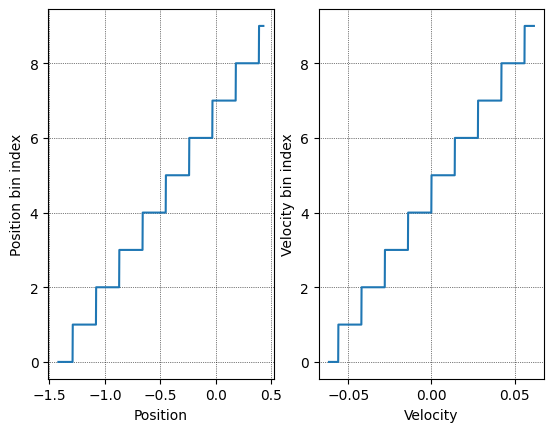

In [5]:
env = MountainCarPhysics()
agent = Agent(env)

pos_min = np.amin(agent.pos_bins)
pos_max = np.amax(agent.pos_bins)
pos_range = np.linspace(pos_min - .1 * np.abs(pos_min),
                        pos_max + .1 * np.abs(pos_max),
                        1000)

pos_idx = np.nan * np.ones_like(pos_range)
for i in range(len(pos_range)):
    pos_idx[i] = agent._get_discrete_state((pos_range[i], 0.))[0]

vel_min = np.amin(agent.vel_bins)
vel_max = np.amax(agent.vel_bins)
vel_range = np.linspace(vel_min - .1 * np.abs(vel_min),
                        vel_max + .1 * np.abs(vel_max),
                        1000)

vel_idx = np.nan * np.ones_like(vel_range)
for i in range(len(vel_range)):
    vel_idx[i] = agent._get_discrete_state((0, vel_range[i]))[1]
    
fig, ax = plt.subplots(ncols = 2)

ax[0].plot(pos_range, pos_idx)
ax[0].set_xlabel(r"Position")
ax[0].set_ylabel(r"Position bin index")

ax[1].plot(vel_range, vel_idx)
ax[1].set_xlabel(r"Velocity")
ax[1].set_ylabel(r"Velocity bin index")

for _ax in ax:
    _ax.grid(True)

## Non-spiking Agent

The traditional, Q-learning agent improves its decision-making by updating a "Q-table", which stores Q-values representing the expected rewards for taking particular actions in given states.

In [6]:
class NonSpikingAgent(Agent):
    def __init__(self, env):
        super().__init__(env)

        # Use defaultdict for Q-table for easier handling of unseen states
        # Q[discrete_state_tuple][action] = value
        self.q_table = defaultdict(lambda: [0.0, 0.0]) # 2 actions: left and right move

    def choose_action(self, discrete_state):
        """Chooses an action using p_explore-greedy policy."""
        if self.rng.random() < self.p_explore:
            return self.rng.choice([AgentAction.LEFT, AgentAction.RIGHT]) # Explore: random action

        # Exploit: choose action with highest Q-value.
        # Handle ties randomly.
        q_values = self.q_table[discrete_state]
        max_q = max(q_values)
        best_actions = [action for action, q in zip(AgentAction, q_values) if q == max_q]

        return self.rng.choice(best_actions)

    def update_q_table(self, current_state, action, next_state, done):
        """Updates the Q-table using the Q-learning formula and reward shaping."""
        current_discrete_state = self._get_discrete_state(current_state)
        next_discrete_state = self._get_discrete_state(next_state)

        # Calculate shaping reward
        current_potential = self._potential(current_state)
        next_potential = self._potential(next_state)
        base_reward = -1.
        total_reward = base_reward + self.discount_factor * next_potential - current_potential
    
        # Q-Learning Update
        old_q_value = self.q_table[current_discrete_state][action.value]

        # Best Q-value for the next state (max_a' Q(s', a'))
        # If terminal state (done), the value of the next state is 0
        next_max_q = max(self.q_table[next_discrete_state]) if not done else 0.0

        if done:
            failure = env.state[0] <= env.min_position
            if failure:
                total_reward = -10.
                
        # Q-update formula
        new_q_value = old_q_value + self.learning_rate * (
            total_reward + self.discount_factor * next_max_q - old_q_value
        )

        self.q_table[current_discrete_state][action.value] = new_q_value
        
        # Return the total (shaped) reward for tracking purposes if needed
        return total_reward



Plot renderer:


In [7]:
class NonSpikingPlotRenderer:
    def __init__(self, env, agent) -> None:
        self.env = env
        self.agent = agent
        self.lifetime_fig, self.lifetime_ax = plt.subplots(nrows=4)
        self.lifetime_ax[0].set_yscale('log')

        self.lifetime_log_line, = self.lifetime_ax[0].plot([], [])
        self.reward_log_line, = self.lifetime_ax[1].plot([], [])
        self.p_explore_log_line, = self.lifetime_ax[2].plot([], [])
        self.learning_rate_log_line, = self.lifetime_ax[3].plot([], [])
        self.lifetime_ax[0].set_ylabel("Steps per episode")
        self.lifetime_ax[1].set_ylabel("Reward per episode")
        self.lifetime_ax[2].set_ylabel("Exploration ratio")
        self.lifetime_ax[3].set_ylabel("Learning rate")
        self.lifetime_ax[-1].set_xlabel("Episode")

    def update(self, episode_idx, lifetime_log, reward_log, p_explore_log, learning_rate_log) -> None:
        if lifetime_log:
            max_lifetime = np.amax(lifetime_log)
            self.lifetime_log_line.set_data(episode_idx, lifetime_log)
            self.lifetime_ax[0].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[0].set_ylim(0, 1.1 * max_lifetime)

        if reward_log:
            self.reward_log_line.set_data(episode_idx, reward_log)
            self.lifetime_ax[1].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[1].set_ylim(np.amin(reward_log), np.amax(reward_log))

        if p_explore_log:
            self.p_explore_log_line.set_data(episode_idx, p_explore_log)
            self.lifetime_ax[2].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[2].set_ylim(np.amin(p_explore_log), np.amax(p_explore_log))

        if learning_rate_log:
            self.learning_rate_log_line.set_data(episode_idx, learning_rate_log)
            self.lifetime_ax[3].set_xlim(episode_idx[0], episode_idx[-1])
            self.lifetime_ax[3].set_ylim(np.amin(learning_rate_log), np.amax(learning_rate_log))

        for _ax in self.lifetime_ax:
            if not _ax == self.lifetime_ax[-1]:
                _ax.set_xticklabels([])

        self.lifetime_fig.canvas.draw()
        self.lifetime_fig.canvas.flush_events()
        self.lifetime_fig.savefig("/tmp/mountain_car_lifetime_nonspiking.png", dpi=300)

        
    def update_q_table_heatmap(self):
        r"""
        Construct heatmap for two parameters
        """
        left_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        right_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        for pos_bin in range(self.agent.NUM_POS_BINS):
            for vel_bin in range(self.agent.NUM_VEL_BINS):
                left_q_table_matrix[pos_bin, vel_bin] = self.agent.q_table[(pos_bin, vel_bin)][AgentAction.LEFT.value]
                right_q_table_matrix[pos_bin, vel_bin] = self.agent.q_table[(pos_bin, vel_bin)][AgentAction.RIGHT.value]
    
        # Determine the overall min and max from all datasets.
        global_min = min(left_q_table_matrix.min(), right_q_table_matrix.min())
        global_max = max(left_q_table_matrix.max(), right_q_table_matrix.max())

        # Use symmetric limits so that zero is centered.
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center.
        norm = mpl.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        
        fig, ax = plt.subplots(nrows=3, figsize=(12, 12))

        im1 = ax[0].imshow(left_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[0].set_title("Q value L")
        im2 = ax[1].imshow(right_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[1].set_title("Q value R")
        im2 = ax[2].imshow(10*(left_q_table_matrix - right_q_table_matrix), cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[2].set_title("Q value L - R (x10)")

        for _ax in ax:
            _ax.set_xlabel(r"pos")
            _ax.set_ylabel(r"vel")

        fig.colorbar(im1, ax=ax.ravel().tolist())
        fig.savefig("/tmp/mountain_car_q_table.png", dpi=300)

        plt.close(fig)



Executing Non-Spiking-Agent:


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 100/1500, Reward: -505.10, Avg Reward (Last 100): -506.48, p_explore: 0.4954


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 200/1500, Reward: -506.81, Avg Reward (Last 100): -495.45, p_explore: 0.2454


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 300/1500, Reward: -253.51, Avg Reward (Last 100): -442.25, p_explore: 0.1216


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 400/1500, Reward: -394.97, Avg Reward (Last 100): -397.30, p_explore: 0.0602


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 500/1500, Reward: -427.03, Avg Reward (Last 100): -384.39, p_explore: 0.0298


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 600/1500, Reward: -241.11, Avg Reward (Last 100): -351.91, p_explore: 0.0148


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 700/1500, Reward: -244.31, Avg Reward (Last 100): -314.58, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 800/1500, Reward: -415.52, Avg Reward (Last 100): -308.01, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 900/1500, Reward: -325.94, Avg Reward (Last 100): -300.50, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1000/1500, Reward: -259.44, Avg Reward (Last 100): -292.67, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1100/1500, Reward: -311.12, Avg Reward (Last 100): -293.76, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1200/1500, Reward: -282.93, Avg Reward (Last 100): -273.56, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1300/1500, Reward: -275.19, Avg Reward (Last 100): -269.94, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1400/1500, Reward: -275.96, Avg Reward (Last 100): -271.74, p_explore: 0.0000


/tmp/ipykernel_22525/3251491258.py:23: UserWarning:Attempt to set non-positive ylim on a log-scaled axis will be ignored.


Episode: 1500/1500, Reward: -276.24, Avg Reward (Last 100): -269.29, p_explore: 0.0000


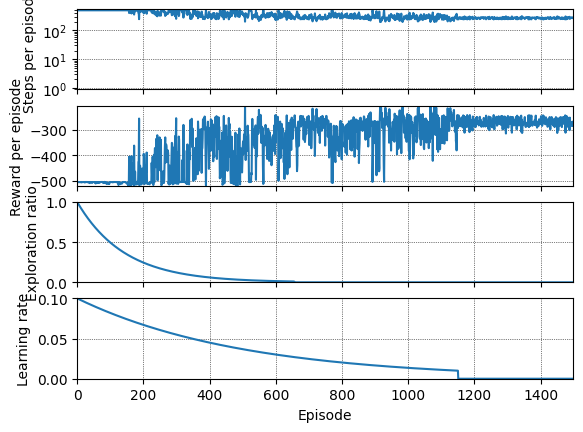

In [8]:
env = MountainCarPhysics()
agent = NonSpikingAgent(env)
r = MountainCarRenderer(env, agent)
r._init_render()
plot = NonSpikingPlotRenderer(env, agent)

episode: int = 0
episode_idx: List[int] = []   # log of number of steps achieved for each episode
steps_per_episode: List[int] = []   # log of number of steps achieved for each episode
learning_rate_log: List[int] = []
p_explore_log: List[int] = []
rewards_per_episode: List[int] = []   # log of total reward achieved in each episode

max_n_episodes: int = 1500
max_steps_per_episode: int = 500   # maximum allowed number of steps per episode

plot_this_episode = True
plot_sim = False
failure = False

render_active = True # Flag to control rendering loop

for episode in range(max_n_episodes):
    done = False

    current_state = env.reset()
    episode_total_reward = 0

    render_this_episode = (episode + 1) % 200 == 0
    plot_this_episode = (episode + 1) % 100 == 0

    for step in range(max_steps_per_episode):
        # poll for events
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
            elif event.type == pygame.KEYDOWN:
                plot_sim ^= pygame.key.get_pressed()[pygame.K_SPACE]
 
        discrete_state = agent._get_discrete_state(current_state)
        action = agent.choose_action(discrete_state)
        next_state, done = env.step(action)

        # Update Q-table and get the total (shaped) reward for this step
        step_reward = agent.update_q_table(current_state, action, next_state, done)
        episode_total_reward += step_reward

        current_state = next_state

        # Render if requested and active
        if render_this_episode and render_active:
            r.render(episode, step + 1, episode_total_reward)

        if done:
            break # End episode

    if plot_this_episode:
        plot.update(episode_idx, steps_per_episode, rewards_per_episode, p_explore_log, learning_rate_log)
        plot.update_q_table_heatmap()

    steps_per_episode.append(step)
    episode_idx.append(episode)
    p_explore_log.append(agent.p_explore)
    learning_rate_log.append(agent.learning_rate)
    rewards_per_episode.append(episode_total_reward)

    agent.decay_p_explore()
    agent.decay_learning_rate()

    if (episode + 1) % 100 == 0:
        avg_reward = sum(rewards_per_episode[-100:]) / 100
        print(f"Episode: {episode + 1}/{max_n_episodes}, "
              f"Reward: {episode_total_reward:.2f}, "
              f"Avg Reward (Last 100): {avg_reward:.2f}, "
              f"p_explore: {agent.p_explore:.4f}")


<span style="background-color:yellow">Task: Make a plot of how much the Q-values changed from before training to after training. Are there certain states that never get updated (that is, is the state space (configuration space) adequately explored)?</span>

# Spiking version

The core principle of our SNN is to simulate the physics and neuron model in sequence, where the state at the end of a physics step is the input for the SNN and the resulting action at the end of a period of SNN simulation is the input to the next physics simulation. Both cycles are set to 25 ms (``SpikingAgent.cycle_period``), a value that is short compared to the typical dynamical timescales in the system, to provide the effect that SNN and physics run simultaneously. 

The SNN model's structure consists of two layers of neurons. For each discrete state of the system, the input layer contains a single neuron encoding it. This is also known as a "one-hot" encoding, because only one input neuron is ever active at any one time. (Note that the computational complexity of this is polynomial in the number of input dimensions—here, position and velocity—and is thus infeasible for more complex systems.) Neuromodulated synapses connect the input layer to the output layer, the latter consisting of two neuron groups which encode the actions "move left" and "move right".

The main loop looks like this: for every iteration of the loop (for every "cycle" or "step"):

- Simulate neural network: 
    - Set the rate of the input neurons to the current state of the environment: get the current state of the mountain car and find the corresponding neuron that only fires when that state is reached; set a nonzero spike rate for that neuron and zero for all the others;
    - Run the SNN with this input state for a period of time (cycle time, here chosen as 25 ms)
    - (The weight trace ``wtr`` is computed in each synapse;)
- An action is selected based on output neuron firing, by counting the number of spikes in the output populations over this cycle period;
- The environment is updated based on action; run the environment for the same cycle time (25 ms) to obtain next state;
- Reward is computed (neuromodulator signal is proportional to TD);
- Synapses that were active (between input and output neurons) have their weights updated (based on ``wtr * TD``)
- Weight trace (``wtr``) of all synapses is reset back to 0.

The TD (temporal difference) signal can be interpreted as follows:

- Positive TD signal: The outcome was better than expected → increase value estimate
- Negative TD signal: The outcome was worse than expected → decrease value estimate
- Zero TD signal: Perfect prediction → no learning needed

In the neuromoduled STDP synapse model, the magnitude of the weight change is larger for pre- and postsynaptic spikes that occur closer together in time. However, in this particular STDP model, there is only a potentiation component and no depression component. This reduces the STDP synapse to a rate-based rule that potentiates more for higher firing rates. For a detailed analysis of the synapse, please see the section "Mechanistic explanation" below.


## NESTML models

Neurons in the input layer will simply be spike generators (called ``ignore_and_fire``) that will fire spikes periodically with a given interval.

The neuron model used for the output layer will be a leaky integrate-and-fire model with postsynaptic currents in the form of a decaying exponential (called ``iaf_psc_exp``).

Input layer neurons are connected to the output layer neurons through the neuromodulated STDP synapse called ``neuromodulated_stdp_synapse``.

The models are defined in ``.nestml`` files in the same directory as the tutorial notebook. We will now generate "user extension module" code for these models, so that they can be instantiated in NEST Simulator.

In [9]:
from pynestml.codegeneration.nest_code_generator_utils import NESTCodeGeneratorUtils

input_layer_module_name, input_layer_neuron_model_name = \
   NESTCodeGeneratorUtils.generate_code_for("../../../models/neurons/ignore_and_fire_neuron.nestml")

output_layer_module_name, output_layer_neuron_model_name, output_layer_synapse_model_name = \
    NESTCodeGeneratorUtils.generate_code_for("iaf_psc_exp_neuron.nestml",
                                             "neuromodulated_stdp_synapse.nestml",
                                             post_ports=["post_spikes"],
                                             logging_level="WARNING",
                                             codegen_opts={"delay_variable": {"neuromodulated_stdp_synapse": "d"},
                                                           "weight_variable": {"neuromodulated_stdp_synapse": "w"}})


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jun  2 2025 16:24:58

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

[12,ignore_and_fire_neuron_nestml, WARNING, [54:34;54:58]]: Model contains a call to fixed-timestep functions (``resolution()`` and/or ``steps()``). This restricts the model to being compatible only with fixed-timestep simulators. Consider eliminating ``resolution()`` and ``steps()`` from the model, and using ``timestep()`` instead.

              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0-post0.dev0
 Built: Jun  2 2025 16:24:58

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out m

## The spiking neural agent

First, we define some helper functions for the visualisation of the network:

In [10]:
def create_weight_matrix(connections):
    """
    Create a weight matrix from NEST connections.
    
    Parameters:
    -----------
    connections : nest.NodeCollection
        Connection object obtained from nest.GetConnections()
        
    Returns:
    --------
    weight_matrix : numpy.ndarray
        Matrix of shape (n_pre, n_post) containing connection weights
    """
    # Get connection properties
    conn_info = connections.get(["source", "target", "weight"])
    
    # Extract source, target, and weight arrays
    sources = np.array(conn_info["source"])
    targets = np.array(conn_info["target"])
    weights = np.array(conn_info["weight"])
    
    # Get unique pre and post neuron IDs
    pre_neurons = np.unique(sources)
    post_neurons = np.unique(targets)
    
    # Create a mapping from neuron IDs to matrix indices
    pre_map = {neuron: i for i, neuron in enumerate(pre_neurons)}
    post_map = {neuron: i for i, neuron in enumerate(post_neurons)}
    
    # Initialize weight matrix with zeros
    n_pre = len(pre_neurons)
    n_post = len(post_neurons)
    weight_matrix = np.zeros((n_pre, n_post))
    
    # Fill the weight matrix
    for src, tgt, w in zip(sources, targets, weights):
        pre_idx = pre_map[src]
        post_idx = post_map[tgt]
        weight_matrix[pre_idx, post_idx] = w
    
    return weight_matrix, pre_neurons, post_neurons

In [11]:
class SpikingPlotRenderer:
    def __init__(self, env, agent) -> None:
        self.env = env
        self.agent = agent

        self.fig, self.ax = plt.subplots(nrows=7, figsize=(12, 10))
        
        # Construct lifetime plot
        self.lifetime_fig, self.lifetime_ax = plt.subplots(nrows=2)
        self.lifetime_line, = self.lifetime_ax[0].plot([0,1], [0,1])
        self.total_reward_per_episode_line, = self.lifetime_ax[1].plot([0,1], [0,1])
        self.lifetime_ax[0].set_ylabel("Steps per episode")
        self.lifetime_ax[1].set_ylabel("Reward per episode")
        self.lifetime_ax[-1].set_xlabel("Episode")

    def update(self, data) -> None:
        if data is None:
            return
        
        self.ax[0].cla()
        self.ax[1].cla()
        self.ax[2].cla()
        self.ax[3].cla()
        self.ax[4].cla()
        self.ax[5].cla()

        # Top plot for spikes
        self.ax[0].set_ylabel("Input Neuron")
        self.ax[0].set_ylim(0, data["n_input_neurons"])
        self.ax[0].plot(data["input_spikes"]["times"], data["input_spikes"]["senders"], ".k", markersize=5)
        
        for neuron_id in np.unique(data["multimeter_left_events"]["senders"]):
            idx = np.where(data["multimeter_left_events"]["senders"] == neuron_id)[0]
            neuron_times = data["multimeter_left_events"]["times"][idx]
            neuron_V_m = data["multimeter_left_events"]["V_m"][idx]
            self.ax[1].plot(neuron_times, neuron_V_m, c="b")

        for neuron_id in np.unique(data["multimeter_right_events"]["senders"]):
            idx = np.where(data["multimeter_right_events"]["senders"] == neuron_id)[0]
            neuron_times = data["multimeter_right_events"]["times"][idx]
            neuron_V_m = data["multimeter_right_events"]["V_m"][idx]
            self.ax[1].plot(neuron_times, neuron_V_m, c="r")
            
        self.ax[1].set_ylabel("V_m [mV]")
        
        self.ax[2].plot(data["model_time_log"], data["n_events_in_last_interval_left_log"], label="left")
        self.ax[2].plot(data["model_time_log"], data["n_events_in_last_interval_right_log"], label="right")
        self.ax[2].legend()
        self.ax[2].set_ylabel("Output Neuron\nfiring rate")
        
        self.ax[3].plot(data["model_time_log"], [action.value for action in data["action_taken"]], "k")
        self.ax[3].set_ylabel("Action taken")
        self.ax[3].set_yticks([AgentAction.LEFT.value, AgentAction.RIGHT.value])
        self.ax[3].set_yticklabels(["LEFT", "RIGHT"])
        
        self.ax[4].plot(data["model_time_log"], data["p_explore_log"], "k")
        self.ax[4].set_ylabel("$p_\mathrm{explore}$")
        self.ax[4].set_ylim(0, 1)
        
        self.ax[5].plot(data["model_time_log"], data["learning_rate_log"], "k")
        self.ax[5].set_ylabel("Learning rate")
        self.ax[5].set_ylim(0, np.amax(data["learning_rate_log"]))
        
        self.ax[6].plot(data["model_time_log"], data["episode_number_detailed_log"], "k")
        self.ax[-1].set_ylabel("Episode")
        
        for _ax in self.ax:
            try:
                _ax.set_xlim(np.min(data["multimeter_right_events"]["times"]), np.max(data["multimeter_right_events"]["times"]))
            except:
                pass
            if not _ax == self.ax[-1]:
                _ax.set_xticklabels([])
        
        self.ax[-1].set_xlabel("Time [ms]")

        # ---------------

        max_lifetime = np.amax(np.array(data["steps_per_episode_log"]) * data["episode_duration"])
        self.lifetime_line.set_data(data["episode_number_log"], np.array(data["steps_per_episode_log"]) * data["episode_duration"])
        self.total_reward_per_episode_line.set_data(data["episode_number_log"], np.array(data["total_reward_per_episode"]))
        for _ax in self.lifetime_ax:
            _ax.set_xlim(data["episode_number_log"][0], data["episode_number_log"][-1])

        if np.amax(data["total_reward_per_episode"]) != np.amin(data["total_reward_per_episode"]):
            self.lifetime_ax[1].set_ylim(np.amin(data["total_reward_per_episode"]), np.amax(data["total_reward_per_episode"]))
        self.lifetime_ax[0].set_ylim(-1E-9, 1.1*max_lifetime)    # the 1E-9 trick is to prevent setting ylim equal to 0, 0 which causes an error
        self.lifetime_ax[0].set_ylabel("Longevity [ms]")
        
        self.ax[-1].set_xlabel("Time [ms]")
        
        self.fig.savefig("/tmp/mountain_car_log.png", dpi=300)
        
        self.lifetime_fig.savefig("/tmp/mountain_car_spiking_lifetime.png", dpi=300)

    def update_weights_heatmap(self):
        neuron_pop_base_gid = np.amin(agent.input_population.tolist())    # id of the first neuron in the NodeCollection
        conn_info_left = self.agent.syn_left.get(["source", "target", "weight"])
        conn_info_right = self.agent.syn_right.get(["source", "target", "weight"])

        left_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        right_q_table_matrix = np.empty((self.agent.NUM_POS_BINS, self.agent.NUM_VEL_BINS))
        for pos_bin in range(self.agent.NUM_POS_BINS):
            for vel_bin in range(self.agent.NUM_VEL_BINS):
                idx = pos_bin + self.agent.NUM_POS_BINS * vel_bin
                input_neuron_gid = neuron_pop_base_gid + idx
                
                # for left

                sources = np.array(conn_info_left["source"])
                targets = np.array(conn_info_left["target"])
                weights = np.array(conn_info_left["weight"])

                assert len(np.unique(targets)) == 1

                idx = np.where(sources == input_neuron_gid)[0]
                
                w = weights[idx]
                
                left_q_table_matrix[pos_bin, vel_bin] = w

                
                # for right

                sources = np.array(conn_info_right["source"])
                targets = np.array(conn_info_right["target"])
                weights = np.array(conn_info_right["weight"])

                assert len(np.unique(targets)) == 1

                idx = np.where(sources == input_neuron_gid)[0]
                
                w = weights[idx]
                
                right_q_table_matrix[pos_bin, vel_bin] = w

                
        # Determine the overall min and max from all datasets
        global_min = min(left_q_table_matrix.min(), right_q_table_matrix.min())
        global_max = max(left_q_table_matrix.max(), right_q_table_matrix.max())

        # Use symmetric limits so that zero is centered
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center
        norm = mpl.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        
        fig, ax = plt.subplots(nrows=3, figsize=(12, 12))

        im1 = ax[0].imshow(left_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[0].set_title("Q value L")
        im2 = ax[1].imshow(right_q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[1].set_title("Q value R")
        im2 = ax[2].imshow(10*(left_q_table_matrix - right_q_table_matrix), cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax[2].set_title("Q value L - R (x10)")

        for _ax in ax:
            _ax.set_xlabel(r"pos")
            _ax.set_ylabel(r"vel")

        fig.colorbar(im1, ax=ax.ravel().tolist())
        fig.savefig("/tmp/weights_matrix.png", dpi=300)

        plt.close(fig)

        ###
        
        fig, ax = plt.subplots(nrows=1)
        
        ax.plot(np.array(conn_info_left["weight"]), label="left")
        ax.plot(np.array(conn_info_right["weight"]), label="right")
        ax.legend()
        fig.savefig("/tmp/weights_spiking_1D.png", dpi=300)

        plt.close(fig)

Then, we define the spiking agent itself:

In [12]:
class SpikingAgent(Agent):
    cycle_period = 25.   # alternate between physics and SNN simulation with this cycle length [ms]
   
    def __init__(self, env) -> None:
        super().__init__(env)
        
        self.Q_left = 0.
        self.Q_right = 0.
        self.Q_left_prev = 0.
        self.Q_right_prev = 0.
        self.Q_old = 0.
        self.Q_new = 0.
        self.scale_n_output_spikes_to_Q_value = 0.1
        self.last_action_chosen = AgentAction.LEFT   # choose first action randomly

        self.POTENTIAL_SCALE_VEL = 10.
        
        self.Wmax = 3.
        self.Wmin = 0.2

        self.n_action_neurons = 1   # number of neurons per action output population (this many for left, and another this many for right, etc.)

        self.INPUT_POPULATION_FIRING_RATE = 500.    # [s⁻¹]
        
        self.construct_neural_network()
        
    def get_state_neuron(self, state) -> int:
        discrete_state = self._get_discrete_state(state)
        idx = discrete_state[0] + self.NUM_POS_BINS * discrete_state[1]
        neuron_pop_base_gid = np.amin(self.input_population.tolist())    # id of the first neuron in the NodeCollection
        
        neuron_gid = neuron_pop_base_gid + idx
        
        if neuron_gid not in self.input_population:
            return None

        return neuron_gid
    
    def construct_neural_network(self):
        nest.ResetKernel()
        nest.local_num_threads = nest_local_num_threads
        nest.resolution = .1    # [ms]
        nest.Install(input_layer_module_name)   # makes the generated NESTML model available
        nest.Install(output_layer_module_name)   # makes the generated NESTML model available

        self.input_size = self.NUM_POS_BINS * self.NUM_VEL_BINS
        self.input_population = nest.Create(input_layer_neuron_model_name, self.input_size)

        self.output_population_left = nest.Create(output_layer_neuron_model_name, self.n_action_neurons)
        self.output_population_right = nest.Create(output_layer_neuron_model_name, self.n_action_neurons)
        
        self.spike_recorder_input = nest.Create("spike_recorder")
        nest.Connect(self.input_population, self.spike_recorder_input)

        self.multimeter_left = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_left, self.output_population_left)
        self.multimeter_right = nest.Create('multimeter', 1, {'record_from': ['V_m']})
        nest.Connect(self.multimeter_right, self.output_population_right)

        self.syn_opts = {"synapse_model": output_layer_synapse_model_name,
                         "weight": .5,
                         "tau_tr_pre": 20., # [ms]
                         "tau_tr_post": 20.,  # [ms]
                         "wtr_max": 0.1,
                         "wtr_min": 0.,
                         "pre_trace_increment": 0.0001,
                         "post_trace_increment": -1.05E-7}

        nest.Connect(self.input_population, self.output_population_left, syn_spec=self.syn_opts)
        nest.Connect(self.input_population, self.output_population_right, syn_spec=self.syn_opts)

        syn = nest.GetConnections(source=self.input_population, target=self.output_population_right)
        self.syn_right = nest.GetConnections(source=self.input_population, target=self.output_population_right)
        self.syn_left = nest.GetConnections(source=self.input_population, target=self.output_population_left)

        self.output_population_spike_recorder_left = nest.Create("spike_recorder")
        nest.Connect(self.output_population_left, self.output_population_spike_recorder_left)

        self.output_population_spike_recorder_right = nest.Create("spike_recorder")
        nest.Connect(self.output_population_right, self.output_population_spike_recorder_right)
        
    def choose_action_based_on_q_values(self) -> AgentAction:
        """Chooses an action using p_explore-greedy policy."""

        # Exploit: choose action with highest Q-value.
        # Handle ties randomly.
        Q_left, Q_right = self.compute_Q_values()
        
        if self.rng.random() < self.p_explore:
            # Explore: random action
            if self.rng.uniform(0, 1) < 0.5:
                self.last_action_chosen = AgentAction.LEFT
                return Q_left, AgentAction.LEFT

            self.last_action_chosen = AgentAction.RIGHT
            return Q_right, AgentAction.RIGHT

        if Q_left > Q_right:
            self.last_action_chosen = AgentAction.LEFT
            return Q_left, AgentAction.LEFT
        
        self.last_action_chosen = AgentAction.RIGHT
        return Q_right, AgentAction.RIGHT
    
    def plot_weight_updates(self, which_side, w, w_old):
        q_table_matrix = np.empty((self.NUM_POS_BINS, self.NUM_VEL_BINS))
        for pos_bin in range(self.NUM_POS_BINS):
            for vel_bin in range(self.NUM_VEL_BINS):
                idx = pos_bin + self.NUM_POS_BINS * vel_bin
                q_table_matrix[pos_bin, vel_bin] = w[idx] - w_old[idx]
                
        # Determine the overall min and max from all datasets.
        global_min = q_table_matrix.min()
        global_max = q_table_matrix.max()

        # Use symmetric limits so that zero is centered.
        limit = max(abs(global_min), abs(global_max))

        # Create a normalization instance that forces 0 to be the center.
        norm = mpl.colors.TwoSlopeNorm(vmin=-limit, vcenter=0, vmax=limit)
        
        fig, ax = plt.subplots(figsize=(12, 12))
        im1 = ax.imshow(q_table_matrix, cmap=plt.cm.coolwarm, norm=norm, interpolation='none')
        ax.set_title("weight update (new - old)")

        ax.set_xlabel(r"pos")
        ax.set_ylabel(r"vel")

        fig.colorbar(im1, ax=ax)
        fig.savefig("/tmp/weights_update_" + which_side + "_" + str(time.time()) + ".png", dpi=300)

        plt.close(fig)

        
        # one-dimensional weight update plot
        fig, ax = plt.subplots(ncols=2, figsize=(12,4))

        ax[0].plot(np.arange(len(w)), w_old, label="w_old")
        ax[0].plot(np.arange(len(w)), w, label="w_new")
        ax[0].legend()
        ax[0].set_title("weights (" + which_side + ")")

        ax[1].set_title("w_new - w_old")
        ax[1].plot(np.arange(len(w)), w - w_old)
        
        print("Updating " + str(len(np.where(np.abs(w - w_old) > 0)[0])) + " weights")

        fig.savefig("/tmp/w_updates_1D_" + which_side + "_" + str(time.time()) + ".png", dpi=300)
        plt.close(fig)

    def compute_Q_values(self) -> None:
        r"""The output of the SNN is interpreted as the (scaled) Q values."""
        self.n_events_in_last_interval_left = self.output_population_spike_recorder_left.n_events
        self.n_events_in_last_interval_right = self.output_population_spike_recorder_right.n_events
        self.Q_left = self.scale_n_output_spikes_to_Q_value * self.n_events_in_last_interval_left
        self.Q_right = self.scale_n_output_spikes_to_Q_value * self.n_events_in_last_interval_right

        self.Q_new = np.amax([self.Q_left, self.Q_right])
        
        return self.Q_left, self.Q_right

    def update(self, next_state: Tuple[float, float]) -> Optional[AgentAction]:
        # Reset output population spike recorders
        self.output_population_spike_recorder_left.n_events = 0
        self.output_population_spike_recorder_right.n_events = 0

        # make the correct input neuron fire
        self.input_population.firing_rate = 0.
        neuron_id = self.get_state_neuron(next_state)
        
        # if state was a failure
        if neuron_id is None:
            return None

        self.input_population[neuron_id].firing_rate = self.INPUT_POPULATION_FIRING_RATE

        # simulate for one cycle
        nest.Simulate(SpikingAgent.cycle_period)

    def _potential(self, state, old_state):
        """
        Calculates the potential function Phi(s) for reward shaping.
        Higher potential should correlate with being closer to the goal state.
        """
        position, velocity = state
        old_position, old_velocity = old_state

        potential_val = 10 * self.env._height(position)
    
#         # reward increasing the velocity
#         if np.abs(velocity) > np.abs(old_velocity):
#             potential_val += 1    # (np.abs(velocity) - np.abs(old_velocity))

        # when going downhill, punish slowing down
        if self.env._height(position) < self.env._height(old_position) and np.abs(velocity) < np.abs(old_velocity):
            potential_val -= 10.
            
        return potential_val

    def update_synaptic_weights(self, Q_new, Q_old, action, reward, reset_traces_at_end_of_step=True):
        if Q_old is None:
            return

        TD = self.discount_factor * Q_new + 10 * reward - Q_old

        if action == AgentAction.RIGHT:
            w = self.syn_right.get("w")
            # w_old = w.copy() # XXX only needed for debugging!
            w += self.learning_rate * TD * np.array(self.syn_right.get("wtr"))
            w = np.minimum(w, self.Wmax)
            w = np.maximum(w, self.Wmin)
            self.syn_right.w = w
            # self.plot_weight_updates("right", w, w_old)
        else:
            assert action == AgentAction.LEFT
            w = self.syn_left.get("w")
            # w_old = w.copy() # XXX only needed for debugging!
            w += self.learning_rate * TD * np.array(self.syn_left.get("wtr"))
            w = np.minimum(w, self.Wmax)
            w = np.maximum(w, self.Wmin)
            self.syn_left.w = w
            # self.plot_weight_updates("left", w, w_old)
            

        #
        #    reset synaptic state
        #

        if reset_traces_at_end_of_step:
            for _syn in [self.syn_left, self.syn_right]:
                _syn.wtr = 0.
                _syn.pre_trace = 0.
                #_syn.post_trace = 0. # need to do this in postsyn. neuron partner instead! See the next two lines

            self.output_population_left.post_trace__for_neuromodulated_stdp_synapse_nestml = 0.
            self.output_population_right.post_trace__for_neuromodulated_stdp_synapse_nestml = 0.

We can now run the simulation by putting together the mountain car physics with the SNN in the main loop:

Episode 0 took: 2.072 s
	Number of steps in episode = 499
	Total reward = -6.571768537791498
Episode 1 took: 2.124 s
	Number of steps in episode = 499
	Total reward = -5.19039522413152
Episode 2 took: 2.367 s
	Number of steps in episode = 499
	Total reward = -13.872030450958711
Episode 3 took: 2.100 s
	Number of steps in episode = 449
	Total reward = 2.2696698077239224
Episode 4 took: 2.470 s
	Number of steps in episode = 499
	Total reward = -4.810795083585302
Episode 5 took: 1.741 s
	Number of steps in episode = 341
	Total reward = 8.276293294583889
Episode 6 took: 2.548 s
	Number of steps in episode = 491
	Total reward = -0.22341812730234079
Episode 7 took: 1.839 s
	Number of steps in episode = 351
	Total reward = 7.15596660228648
Episode 8 took: 2.131 s
	Number of steps in episode = 423
	Total reward = 4.115677345994694
Episode 9 took: 2.547 s
	Number of steps in episode = 485
	Total reward = 2.4359103775790394


/tmp/ipykernel_22525/516419963.py:120: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_22525/516419963.py:135: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Episode 10 took: 2.903 s
	Number of steps in episode = 498
	Total reward = 1.427414090888584
Episode 11 took: 2.747 s
	Number of steps in episode = 499
	Total reward = -0.8675605990046993
Episode 12 took: 2.815 s
	Number of steps in episode = 499
	Total reward = -2.614152588149077
Episode 13 took: 2.813 s
	Number of steps in episode = 471
	Total reward = 4.57502823374634
Episode 14 took: 2.913 s
	Number of steps in episode = 476
	Total reward = 4.0343901898932675
Episode 15 took: 2.795 s
	Number of steps in episode = 442
	Total reward = 3.500417295266188
Episode 16 took: 2.690 s
	Number of steps in episode = 383
	Total reward = 7.561476895082343
Episode 17 took: 3.262 s
	Number of steps in episode = 473
	Total reward = 3.5659861246914084
Episode 18 took: 3.015 s
	Number of steps in episode = 454
	Total reward = 2.39207412096165
Episode 19 took: 12.232 s
	Number of steps in episode = 442
	Total reward = 3.180317693753257


/tmp/ipykernel_22525/516419963.py:120: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_22525/516419963.py:135: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Episode 20 took: 3.398 s
	Number of steps in episode = 470
	Total reward = 3.6261927930092166
Episode 21 took: 3.401 s
	Number of steps in episode = 475
	Total reward = 3.2414708376777224
Episode 22 took: 3.667 s
	Number of steps in episode = 499
	Total reward = 0.2641690601681379
Episode 23 took: 3.578 s
	Number of steps in episode = 489
	Total reward = 2.033950892654474
Episode 24 took: 3.567 s
	Number of steps in episode = 470
	Total reward = 4.02203641546302
Episode 25 took: 4.339 s
	Number of steps in episode = 499
	Total reward = 0.2538028721419012
Episode 26 took: 3.720 s
	Number of steps in episode = 420
	Total reward = 4.8656779515640345
Episode 27 took: 4.268 s
	Number of steps in episode = 492
	Total reward = 1.463498464463361
Episode 28 took: 2.976 s
	Number of steps in episode = 351
	Total reward = 6.559925476344539
Episode 29 took: 3.141 s
	Number of steps in episode = 376
	Total reward = 8.06510862261401


/tmp/ipykernel_22525/516419963.py:120: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_22525/516419963.py:135: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Episode 30 took: 4.012 s
	Number of steps in episode = 447
	Total reward = 5.736444971973054
Episode 31 took: 3.759 s
	Number of steps in episode = 414
	Total reward = 4.033955350325707
Episode 32 took: 4.753 s
	Number of steps in episode = 499
	Total reward = 0.6403141816248414
Episode 33 took: 4.852 s
	Number of steps in episode = 499
	Total reward = -1.4082959714880707
Episode 34 took: 4.986 s
	Number of steps in episode = 474
	Total reward = 4.135084847299336
Episode 35 took: 5.040 s
	Number of steps in episode = 499
	Total reward = -6.351861565861838
Episode 36 took: 5.134 s
	Number of steps in episode = 499
	Total reward = -8.032888960153212
Episode 37 took: 5.237 s
	Number of steps in episode = 499
	Total reward = -2.84738271039367
Episode 38 took: 5.522 s
	Number of steps in episode = 499
	Total reward = -6.077593949329013
Episode 39 took: 5.158 s
	Number of steps in episode = 472
	Total reward = 2.8466066761981885


/tmp/ipykernel_22525/516419963.py:120: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_22525/516419963.py:135: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


Episode 40 took: 5.416 s
	Number of steps in episode = 480
	Total reward = 1.7855389496985774
Episode 41 took: 4.780 s
	Number of steps in episode = 433
	Total reward = 3.228520915671402
Episode 42 took: 5.559 s
	Number of steps in episode = 496
	Total reward = -2.3871516078153805
Episode 43 took: 5.423 s
	Number of steps in episode = 464
	Total reward = 3.6281908642250578
Episode 44 took: 5.567 s
	Number of steps in episode = 481
	Total reward = 1.559397872573852
Episode 45 took: 5.522 s
	Number of steps in episode = 473
	Total reward = 2.9103789490908967
Episode 46 took: 5.453 s
	Number of steps in episode = 457
	Total reward = 4.026032199679252
Episode 47 took: 5.338 s
	Number of steps in episode = 444
	Total reward = 3.0325767959556384
Episode 48 took: 6.114 s
	Number of steps in episode = 495
	Total reward = 0.618114235047786
Episode 49 took: 6.478 s
	Number of steps in episode = 499
	Total reward = -4.731807474432128


/tmp/ipykernel_22525/516419963.py:120: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
/tmp/ipykernel_22525/516419963.py:135: DeprecationWarning:Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)


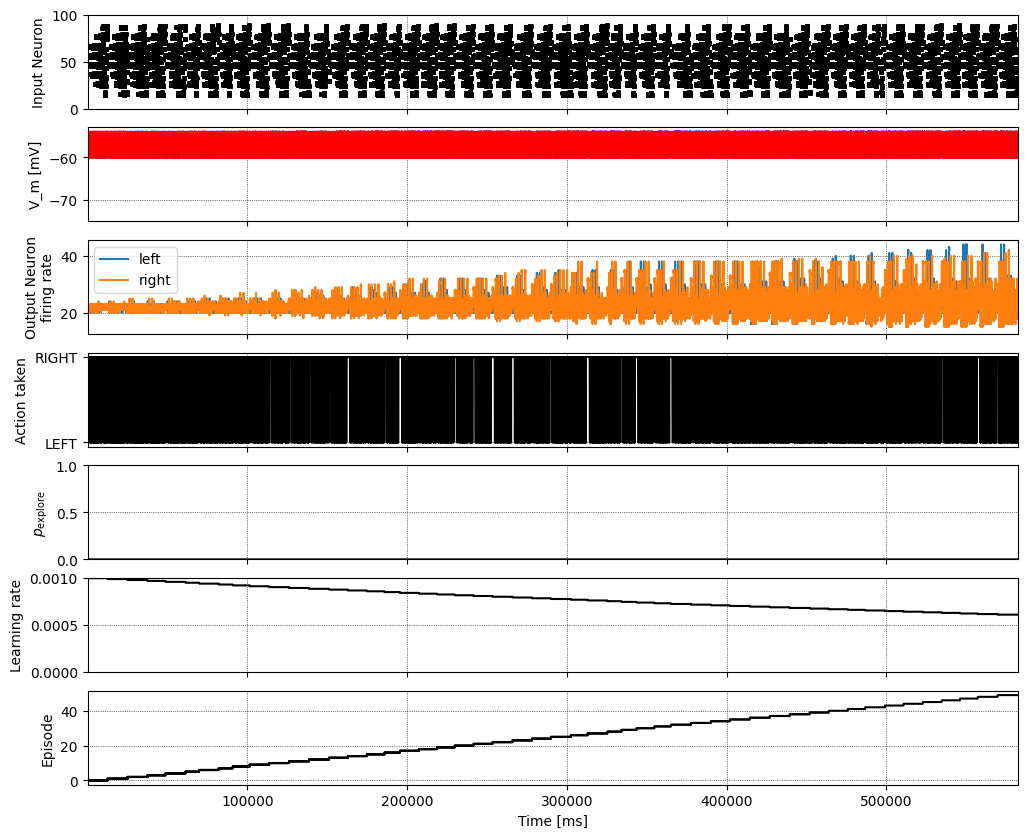

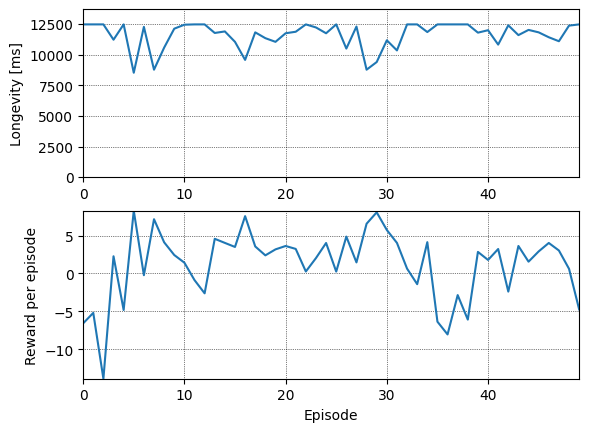

In [13]:
env = MountainCarPhysics()
agent = SpikingAgent(env)

agent.p_explore = 0. # XXX: no exploration! not necessary
agent.learning_rate = 0.001
agent.learning_rate_decay = .99
agent.MIN_LEARNING_RATE = agent.learning_rate / 100.

r = MountainCarRenderer(env, agent)
r._init_render()
plot = SpikingPlotRenderer(env, agent)

episode_number_log = []
episode_number_detailed_log = []
steps_per_episode_log = []
episode_number_times = []
episode_number_at_time = []
n_events_in_last_interval_left_log = []
n_events_in_last_interval_right_log = []

model_time_log = []
action_taken = []
p_explore_log = []
rewards_per_episode: List[int] = []   # log of total reward achieved in each episode
learning_rate_log = []

syn_to_left = nest.GetConnections(source=agent.input_population, target=agent.output_population_left)
syn_to_right = nest.GetConnections(source=agent.input_population, target=agent.output_population_right)

max_n_episodes: int = 50
max_steps_per_episode: int = 500   # maximum allowed number of steps per episode

plot_this_episode = True
plot_sim = False
failure = False

# agent chooses action, simulation is updated and reward is calculated

render_active = True # Flag to control rendering loop

Q_old = None
env.reset()
old_state = copy.copy(env.state)

for episode in range(max_n_episodes):
    render_this_episode = False
    plot_this_episode = (episode + 1) % 10 == 0

    env.reset()
    
    episode_total_reward = 0

    start_time_episode = time.time()
    
    for step in range(max_steps_per_episode):

        #
        #    agent chooses action
        #

        agent.update(env.state)
        Q_max, action = agent.choose_action_based_on_q_values()

        if action is None:
            # failure
            break
            
        #
        #    step environment using action
        #
            
        old_old_state = copy.copy(old_state)
        old_state = copy.copy(env.state)
        _, env_done = env.step(action)

        if env_done:
            # success!
            agent.update_synaptic_weights(Q_new=Q_max,
                                          Q_old=Q_old,
                                          action=action,
                                          reward=1.)
            break

        #
        #    change synaptic weights based on environment reward
        #

        step_reward = agent.discount_factor * agent._potential(env.state, old_state) - agent._potential(old_state, old_old_state)   # compute reward in the new state
        agent.update_synaptic_weights(Q_new=Q_max,
                                      Q_old=Q_old,
                                      action=action,
                                      reward=step_reward)

        Q_old = Q_max
        

        #
        #    Render if requested and active
        #
        
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                sys.exit()
                quit()
            elif event.type == pygame.KEYDOWN:
                render_this_episode ^= pygame.key.get_pressed()[pygame.K_SPACE]
 
        if render_this_episode and render_active:
            r.render(episode, step + 1, step_reward, action)

            
        #
        #    logging
        #

        episode_total_reward += step_reward

        p_explore_log.append(agent.p_explore)
        learning_rate_log.append(agent.learning_rate)
        model_time_log.append(nest.biological_time)
        action_taken.append(action)
        episode_number_detailed_log.append(episode)
        n_events_in_last_interval_left_log.append(agent.n_events_in_last_interval_left)
        n_events_in_last_interval_right_log.append(agent.n_events_in_last_interval_right)
        
    #
    #    print performance stats
    #

    end_time_episode = time.time()
    time_episode = end_time_episode - start_time_episode
    print(f"Episode " + str(episode) + f" took: {time_episode:.3f} s")
    print("\tNumber of steps in episode = " + str(step))
    print("\tTotal reward = " + str(episode_total_reward))

    episode_number_log.append(episode)
    steps_per_episode_log.append(step)
    rewards_per_episode.append(episode_total_reward)
            
    if plot_this_episode:
        plot_data = {
            "input_spikes": nest.GetStatus(agent.spike_recorder_input, keys="events")[0],
            "output_spikes_left": nest.GetStatus(agent.output_population_spike_recorder_left, keys="events")[0],
            "output_spikes_right": nest.GetStatus(agent.output_population_spike_recorder_right, keys="events")[0],
            "multimeter_right_events": agent.multimeter_right.get("events"),
            "multimeter_left_events": agent.multimeter_left.get("events"),
            "n_input_neurons": agent.input_size,
            "total_reward_per_episode": rewards_per_episode
        }

        plot_data["model_time_log"] = model_time_log
        plot_data["action_taken"] = action_taken
        plot_data["p_explore_log"] = p_explore_log
        plot_data["learning_rate_log"] = learning_rate_log
        plot_data["episode_number_log"] = episode_number_log
        plot_data["episode_number_detailed_log"] = episode_number_detailed_log
        plot_data["episode_duration"] = agent.cycle_period
        plot_data["steps_per_episode_log"] = steps_per_episode_log
        plot_data["Wmin"] = agent.Wmin
        plot_data["Wmax"] = agent.Wmax
        plot_data["n_events_in_last_interval_left_log"] = n_events_in_last_interval_left_log
        plot_data["n_events_in_last_interval_right_log"] = n_events_in_last_interval_right_log

        plot.update(plot_data)
        plot.update_weights_heatmap()
        
    agent.decay_p_explore()
    agent.decay_learning_rate()

In [14]:
# run this cell to do benchmarking! 
# %%prun -s cumulative
# main_simulation_loop()

## Mechanistic explanation: why does this learning principle work?

The neuromoduled STDP synapse used in the SNN only as a potentiation component, and no depression. This reduces the model to a Hebbian firing-rate rule: if the pre- and postsynaptic neuron fire at higher rates, their connection tends to become strenghtened.

This can be shown by plotting the change in weight as a function of pre- and postsynaptic firing rate for a single synapse. Observe that more potentiation happens as the firing rates become higher.

In [15]:
def run_stdp_firing_rate_experiment(alpha=0., debug=False):
    #
    #    Simulation parameters
    #

    duration = 1000.  # Duration of each individual simulation [ms]
    dt = 0.1         # Simulation time step [ms]

    #
    #    STDP synapse parameters
    #

    # This script uses NEST's standard 'stdp_synapse' model.
    learning_rate = 0.001    # LTP/LTD amplitude change (NEST's 'lambda')
    alpha = alpha    # ratio between LTP and LTD amplitude change (NEST's 'alpha')
    w_max = 1.       # Maximum synaptic weight
    initial_weight = 0.5 # Starting weight for the synapse

    #
    #    Firing rate parameters
    #

    # Range of firing rates to test (in s⁻¹)
    pre_rates = np.linspace(5, 100, 10)
    post_rates = np.linspace(5, 100, 10)

    #
    #    Main loop
    #

    # Iterate over every combination of presynaptic and postsynaptic firing rates
    weight_changes = np.zeros((len(pre_rates), len(post_rates)))  # Initialize a matrix to store the final weight change for each rate pair
    for i, pre_rate in enumerate(pre_rates):
        for j, post_rate in enumerate(post_rates):
            if debug:
                print(f"Simulating: Pre-rate={pre_rate:.1f} s⁻¹, Post-rate={post_rate:.1f} s⁻¹")

            # Reset NEST Kernel: Ensures that each simulation run is independent and starts from a clean state
            nest.ResetKernel()
            nest.resolution = dt
            nest.print_time = False    # Suppress NEST's progress output for a cleaner console
            nest.local_num_threads = 1    # Ensures reproducibility for this script

            # Create network nodes
            # The presynaptic neuron is a simple Poisson spike generator
            pre_generator = nest.Create("poisson_generator", params={"rate": pre_rate})
            pre_parrot = nest.Create("parrot_neuron")
            nest.Connect(pre_generator, pre_parrot)

            sr_pre = nest.Create("spike_recorder")
            sr_post = nest.Create("spike_recorder")

            # The postsynaptic neuron must be a spiking model for STDP to work
            # We use a standard leaky integrate-and-fire neuron model
            post_neuron = nest.Create("iaf_psc_alpha")

            nest.Connect(pre_parrot, sr_pre)
            nest.Connect(post_neuron, sr_post)

            # To control the postsynaptic firing rate, we drive it with another generator
            # This driver provides strong input to make the post_neuron fire at the target rate
            post_driver = nest.Create("poisson_generator", params={"rate": post_rate})

            # --- Configure Synapse Model ---
            # Define the parameters for NEST's built-in STDP synapse model
            stdp_params = {
                "lambda": learning_rate,        # Potentiation step
                "alpha": alpha,       # Depression step (as a positive factor)
                "Wmax": w_max,          # Upper bound for the weight
                "weight": initial_weight,
                "mu_plus": 0.,
                "mu_minus": 0.,
                "delay": dt,            # Minimum delay
            }
            # Create a custom synapse name based on the standard model
            nest.CopyModel("stdp_synapse", "custom_stdp_synapse", params=stdp_params)

            nest.Connect(pre_parrot, post_neuron, syn_spec={"synapse_model": "custom_stdp_synapse"})
            nest.Connect(post_driver, post_neuron, syn_spec={"weight": 2000.})

            #
            #   Run simulation
            #

            # We need the initial state to calculate the change later
            connection = nest.GetConnections(pre_parrot, post_neuron)
            initial_w = nest.GetStatus(connection, "weight")[0]

            nest.Simulate(duration)

            assert len(sr_pre.events["times"]) > 0
            if debug:
                print("\t-> Actual pre rate: " + str(len(sr_pre.events["times"]) / (duration / 1000)) + " s⁻¹")
            assert len(sr_post.events["times"]) > 0
            if debug:
                print("\t-> Actual post rate: " + str(len(sr_post.events["times"]) / (duration / 1000)) + " s⁻¹")

            # Retrieve the weight after the simulation has finished
            final_w = nest.GetStatus(connection, "weight")[0]
            weight_changes[i, j] = final_w - initial_w


    #
    #    Plotting
    #

    # Create a custom colormap: blue -> white -> red
    colors = [(0, 0, 1), (1, 1, 1), (1, 0, 0)]  # Blue, White, Red
    cmap = mpl.colors.LinearSegmentedColormap.from_list('stdp_cmap', colors, N=256)

    # Automatically determine the color limits to be symmetric around zero
    v_limit = np.max(np.abs(weight_changes))

    # Create the figure and axes
    plt.figure(figsize=(8, 6))
    im = plt.imshow(
        weight_changes, 
        cmap=cmap,
        extent=[post_rates[0], post_rates[-1], pre_rates[0], pre_rates[-1]],
        origin='lower', 
        aspect='auto', 
        vmin=-v_limit, 
        vmax=v_limit
    )

    plt.colorbar(im, label='Change in Synaptic Weight')
    plt.xlabel('Postsynaptic Firing Rate [s⁻¹]')
    plt.ylabel('Presynaptic Firing Rate [s⁻¹]')
    plt.title(f'STDP Weight Change vs. Firing Rates ({int(duration)} ms) - NEST Simulator')
    plt.grid(False)
    plt.tight_layout()

    plt.show()

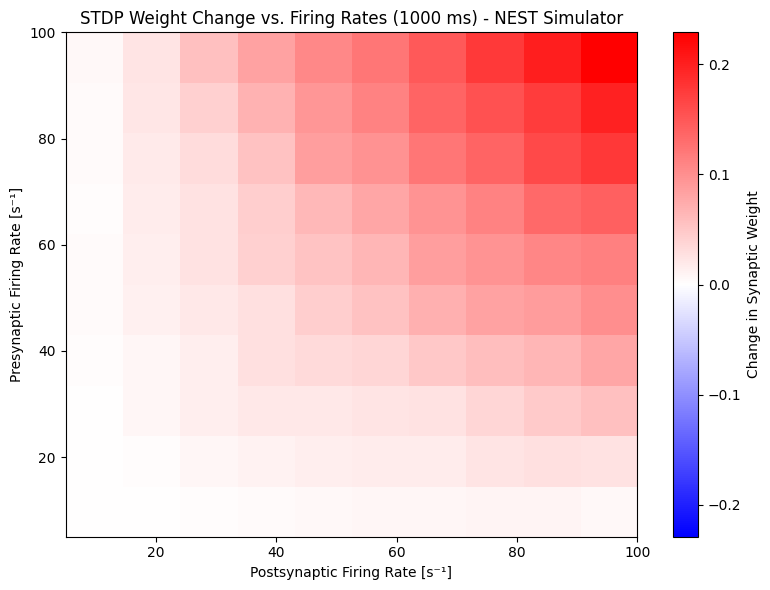

In [16]:
run_stdp_firing_rate_experiment()

By comparison, if we use the normal STDP rule, that has a depression component equal in magnitude to the facilitation component, no clear patterns of firing rate dependence emerges:

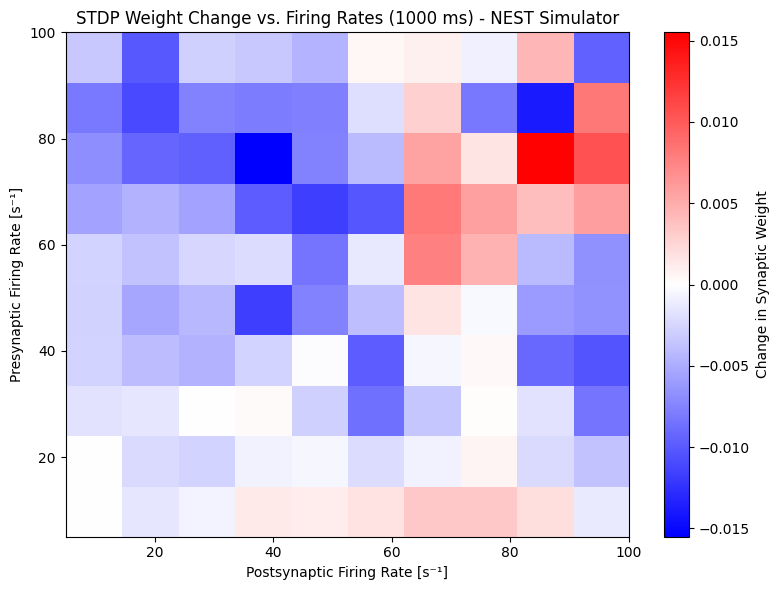

In [17]:
run_stdp_firing_rate_experiment(alpha=1.)

Because of the activity of the neuromodulator in the mountain-car network (in addition to the basic STDP mechanism), only the connections between the input neuron that are active, and the output layer neuron for the action that was chosen, will be updated, proportional to the reward obtained. Thus, the weight increase is proportional to the reward, ensuring that successful input state/output action mappings get strengthened.

# Citations

[1] Liu Y, Pan W. Spiking Neural-Networks-Based Data-Driven Control. Electronics. 2023; 12(2):310. https://doi.org/10.3390/electronics12020310 

[2] Kaiser, Jacques & v. Tieck, J. Camilo & Hubschneider, Christian & Wolf, Peter & Weber, Michael & Hoff, Michael & Friedrich, Alexander & Wojtasik, Konrad & Roennau, Arne & Kohlhaas, Ralf & Dillmann, Rüdiger & Zöllner, J.. (2016). Towards a framework for end-to-end control of a simulated vehicle with spiking neural networks. 10.1109/SIMPAR.2016.7862386.

[3] Pygame community (2025). Pygame (computer software). Retrieved from https://www.pygame.org/



## Acknowledgements

The authors would like to thank Prof. Wei Pan and Dr. Yuxiang Liu for kindly providing the source code for their original publication. 

This software was developed in part or in whole in the Human Brain Project, funded from the European Union’s Horizon 2020 Framework Programme for Research and Innovation under Specific Grant Agreements No. 720270 and No. 785907 (Human Brain Project SGA1 and SGA2).

## Copyright

This file is part of NEST.

Copyright (C) 2004 The NEST Initiative

NEST is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 2 of the License, or (at your option) any later version.

NEST is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with NEST. If not, see http://www.gnu.org/licenses/.